In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
base_shape_size = 8192
ws = 255
ol = 128
input_shape = (128, 64, 2)

In [3]:
from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance, calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from sound import Sound
from data_generators import NoisyTargetGenerator, NoisyTargetDoubleGenerator
from artigos import DeepNoiseSuppressionWithNonIntrusivePESQNet
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
import tensorflow as tf

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
from IPython import display
import librosa

In [4]:
sound_base = Sound('../../../Dados/Vozes/', '../../../Dados/Ruido/', base_shape_size)

Loading Noise Files: 100%|██████████| 8137/8137 [00:06<00:00, 1323.53it/s]
/tf/utils/sound.py:65: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  clean_sounds = [sound for sound in clean_sounds if sound != self.TOO_SHORT_ERROR]
/tf/utils/sound.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_sounds = [sound for sound in noise_sounds if sound != self.TOO_SHORT_ERROR]


In [5]:
data_generator_train = NoisyTargetGenerator(sound_base.train_X, sound_base.noise_sounds)
data_generator_val = NoisyTargetGenerator(sound_base.val_X, sound_base.noise_sounds)

In [6]:
models_class = DeepNoiseSuppressionWithNonIntrusivePESQNet(input_shape)

In [7]:
input_module = Input(shape=input_shape)

module_output = models_class.DNSModel(input_module)
# dns_module = models_class.DNSModel(dns_module)
# dns_module = models_class.DNSModel(dns_module)
# module_output = models_class.DNSModel(dns_module)

model = Model(inputs=input_module, outputs=module_output)

In [8]:
# Compile o modelo com sua escolha de otimizador e função de perda
model.compile(optimizer='adam', loss='msle')

# Resumo do Modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 64, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 64, 2)  8           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 128, 64, 64)  3264        ['batch_normalization[0][0]']    
                                                                                              

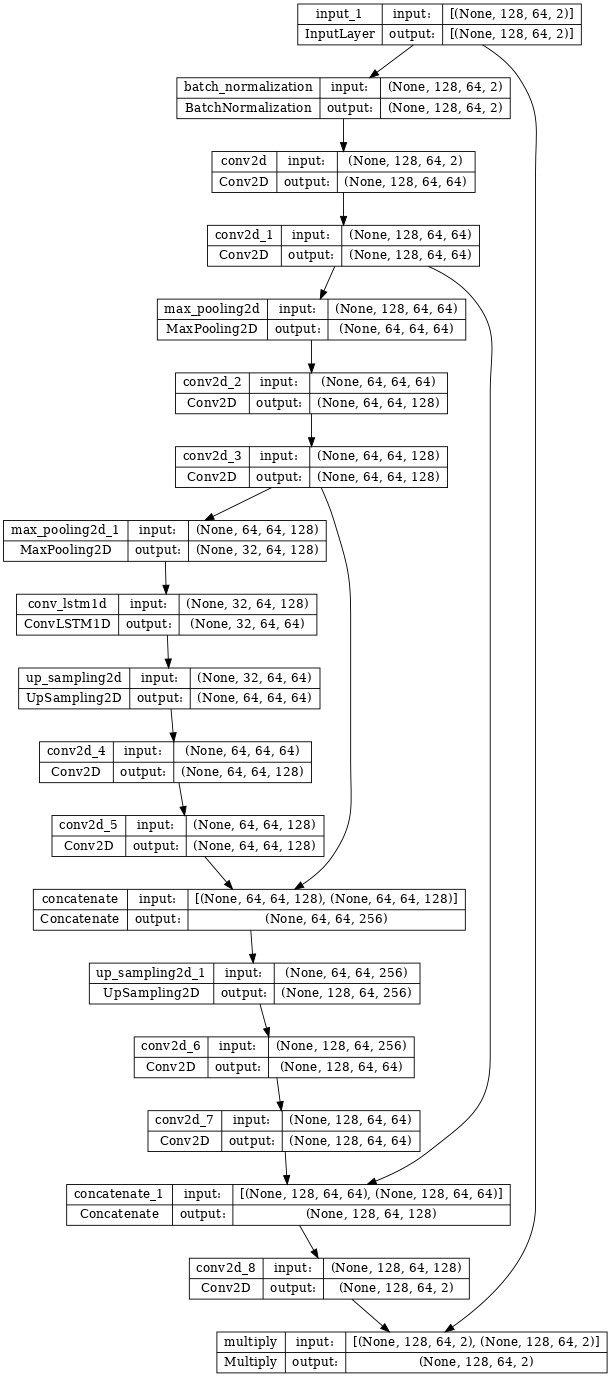

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [10]:
def generate_images(model, test_input, tar):
    
    prediction = model(test_input, training=True)
    plt.figure(figsize=(22, 7))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Log Power Spectrum - Som ruidoso', 'Log Power Spectrum - Som original', 'Log Power Spectrum - Som filtrado']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(10 * np.log10((display_list[i][..., 0])**2), aspect='auto', cmap='inferno')
        plt.colorbar(format='%+2.0f dB')  # Removi a variável 'im' e 'axs[0]'
        plt.axis('off')
    
    plt.show()

In [19]:
batch_size = 64
steps_per_epoch = len(sound_base.train_X) // batch_size

print('Starting training')

for i, epoch in enumerate(range(20)):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_completo(batch_size=batch_size))
    x_val, y_val = validation_batch

    # pbar = tqdm(range(100))
    

    model.fit(data_generator_train.generate_sample_completo(batch_size=batch_size, include_clean=True),
              steps_per_epoch=steps_per_epoch,
              epochs=1,
              validation_data=(x_val, y_val),
             )
    
    # if i % 2 == 0: 
    indice_aleatorio = np.random.choice(x_val.shape[0])
    
    # Selecione a amostra correspondente
    amostra_noisy_module = x_val[indice_aleatorio]
    # amostra_noisy_phase = x_val[1][indice_aleatorio]
    # amostra_noisy = np.concatenate([amostra_noisy_module, amostra_noisy_phase], axis=-1)
    amostra_noisy_module = amostra_noisy_module[np.newaxis, ...]
    
    # amostra_original = y_val[indice_aleatorio]
    # amostra_original = amostra_original[np.newaxis, ...]

    amostra_original_module = y_val[indice_aleatorio]
    # amostra_noisy_phase = y_val[1][indice_aleatorio]
    # amostra_original = np.concatenate([amostra_original_module, amostra_noisy_phase], axis=-1)
    amostra_original_module = amostra_original_module[np.newaxis, ...]
    
    generate_images(model, amostra_noisy_module, amostra_original_module)

Starting training
Epoch 1


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/conv2d_6/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_33/832595383.py", line 16, in <module>
      model.fit(data_generator_train.generate_sample_completo(batch_size=batch_size, include_clean=True),
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer.py", line 542, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer.py", line 275, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/model/conv2d_6/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[128,256,128,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/conv2d_6/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6663]

In [42]:
x_test, y_test = next(data_generator_train.generate_sample_completo(batch_size=8))
F_f = model.predict(x_test)

1/1 [==============================] - 0s 31ms/step


In [43]:
F_f.shape

(8, 128, 64, 2)

In [44]:
# x_test = x_test[0]
# y_test = y_test[0]
# F_f = F_f[0]

A = y_test[0][:, :,0]
phi = (y_test[0][:, :,1] - 0.5) * 2 * np.pi

A_f = F_f[0][:, :,0]
phi_f = (F_f[0][:, :, 1] - 0.5) * 2 * np.pi

A_n = x_test[0][:, :, 0]
phi_n = (x_test[0][:, :, 1] - 0.5) * 2 * np.pi

s = reconstruct_signal_from_stft(A, phi)
s_n = reconstruct_signal_from_stft(A_n, phi_n)
s_f = reconstruct_signal_from_stft(A_f, phi_f)

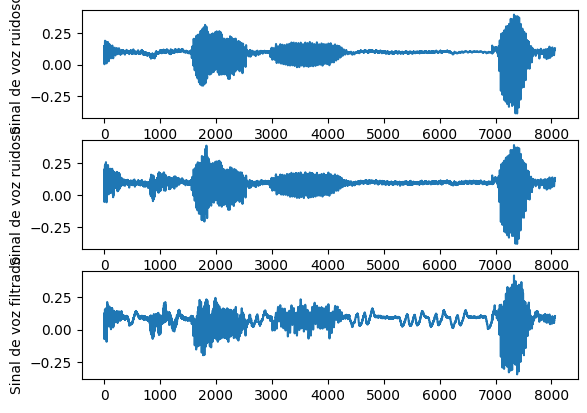

In [45]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz ruidoso')

# Plotando o primeiro array
ax2.plot(s_n)
ax2.set_ylabel('Sinal de voz ruidoso')

ax3.plot(s_f)
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [46]:
Audio(data=s, rate=8000)

In [47]:
Audio(data=s_n, rate=8000)

In [48]:
Audio(data=s_f, rate=8000)

In [41]:
import datetime
# Get the current datetime
current_datetime = datetime.datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

model.save('DNS-loss-0.0197-epochs-1-'+datetime_str+'.h5')